This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fds-courses%2Foptimal-filtering-sicom/master?urlpath=lab/tree/notebooks%2F1_Wiener_non_causal%2FN2_deconvolution_image_Wiener_smoothing.ipynb)


*Adapted from the [Numerical Tours of Data Sciences](https://www.numerical-tours.com/python/) examples*

# Image Deconvolution using Wiener Smoothing

In [1]:
from numpy import *
from scipy import signal
from numpy.fft import *
import matplotlib.pyplot as plt

We consider here the deconvolution problem: the measurement $y$ are assumed to be blurry and possibly noisy:

$$y= a \star x + v,$$

where $a$ is the (low pass) filter and $v$ some possible noise. In the following, we assume that there is no noise ($v=0$), thus $y = a \star x$ .

The objective of inverse filtering is to recover the original image $x$ from the measurement $y$.

The code cells below allow to
- Load, blur and display both the sharp and the blurred image
- Compute and display the inverse filtered image
- Compute, compare and display the Wiener solution with regularization (with equivalent noise)
- Compute and display the SNRs curve vs the power of the equivalent noise

## Image blurring

Deconvolution corresponds to removing a blur from an image. We use here a Gaussian blur.

#### Image Loading

First we load image _Ascent_ (convenient image to use for testing and demonstration which is open source conversely to Lena). We store it in the variable `x_sharp`
We denote it as _sharp_, because the image is clean, not degraded.

In [2]:
from scipy import misc

x_sharp = misc.ascent()
print("The size of the image is {} x {}.".format(x_sharp.shape[0], x_sharp.shape[1]))
print(
    "The range of the pixel values is [{:.0f},{:.0f}].".format(
        x_sharp.min(), x_sharp.max()
    )
)
x_sharp = x_sharp.astype(
    float
)  # cast so that the pixel values are floating point numbers

The size of the image is 512 x 512.
The range of the pixel values is [0,255].


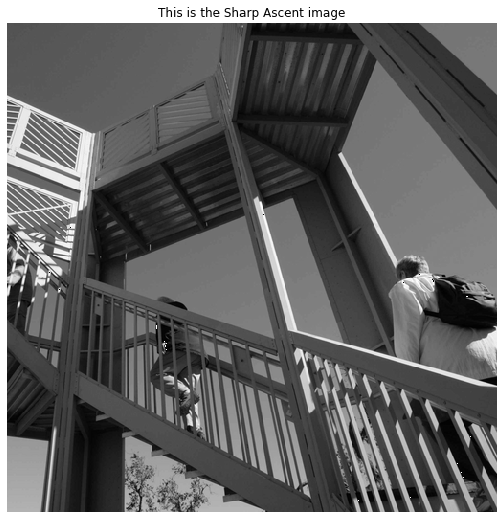

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(9, 9))
ax.imshow(x_sharp, interpolation="nearest", cmap="gray")
ax.axis("off")
ax.set_title("This is the Sharp Ascent image");

#### Convolution 

We build a convolution kernel $a$

Bandwidth $s$ of the kernel, in pixel, and radius $r_{trunc}$ of the truncated kernel

In [4]:
s = 5
r_trunc = 5 * s + 1

Define the convolution kernel $a(\cdot)$ as a 2D Gaussian kernel truncated on $[-r_{trunc},r_{trunc}] \times [-r_{trunc},r_{trunc}]$

In [5]:
n = x_sharp.shape[0]  # here a square image
#  we set the center of the kernel in the (0,0) pixel location.
xx = concatenate((arange(0, n / 2), arange(-n / 2, 0)))
[YY, XX] = meshgrid(xx, xx)
a = exp((-(XX ** 2) - YY ** 2) / (2 * s ** 2))
# Truncation
a[abs(XX) > r_trunc] = 0
a[abs(YY) > r_trunc] = 0
# Normalization
a = a / sum(a.flatten())

We are going to use Fourier transform to compute the convolution. Note it should be real because of the kernel symmetry:

In [6]:
aF = real(fft2(a))

Display the kernel and its transform.
We use `fftshift` to center the filter for display.

In [7]:
_, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(fftshift(a), interpolation="nearest", cmap="gray")
ax[0].axis("off")
ax[0].set_title("Filter a")
ax[1].imshow(20 * log10(abs(fftshift(aF))), interpolation="nearest", cmap="gray")
ax[1].axis("off")
ax[1].set_title("Modulous of the Fourier Transform aF (dB)");

**Exercise:** 
- Can you explain the _grid effect_ for the Fourier Tranform `aF` of the filter? 

We use this short hand for the filtering.
Note that this is a symmetric operator.

In [8]:
Phi = lambda x, h: real(ifft2(fft2(x) * fft2(h)))

Apply the filter.

In [9]:
y_blur = Phi(x_sharp, a)

Display the filtered observations.

In [10]:
from numpy.linalg import norm


def snr(y0, y):
    return 20 * log10(norm(y0) / norm(y0 - y))

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].imshow(x_sharp, interpolation="nearest", cmap="gray")
ax[0].axis("off")
ax[0].set_title("Sharp Ascent image")
ax[1].imshow(y_blur, interpolation="nearest", cmap="gray")
ax[1].axis("off")
ax[1].set_title("Blurred (w/o noise) image, SNR={:.2f}".format(snr(x_sharp, y_blur)));

## Deconvolution: inverse filter

Remember than in the general case of convolution+noise, the Wiener filter has Fourier Transform
$$ G(\nu) = \frac{1}{A(\nu)} \frac{1}{1+\rho^{-1}(\nu)},$$
where $\rho^{-1}(\nu)$ is the inverse SNR for frequency $\nu$.

In the absence of noise, $\rho^{-1}(\nu)=0$ and the optimal deconvolution filter reduces to
$$G(\nu) = \frac{1}{A(\nu)},$$ i.e. the inverse filter of $A(\nu)$. 


The inverse filtered (Fourier Transform) image is simply obtained by dividing the Fourier transform of $y$, denoted as ${Y(\nu)}$,
by ${A(\nu)}$, the Fourier Transform of the filter $a(\cdot)$.

$${\hat X}(\nu) = \frac{Y(\nu)}{ A(\nu)} = \frac{A(\nu) X_{sharp}(\nu)}{ A(\nu)} = X_{sharp}(\nu)$$

Hence, $\hat x = x_{sharp}$. In the absence of noise, the simple inverse filter should deliver a (theoretically) perfect estimate! The use of Wiener filtering seems quite overkilling here...

In [12]:
# Useful for later: Fourier transform of the sharp and observed images
xF = fft2(x_sharp)
yF = fft2(y_blur)
# 'optimal' deconvolution : inverse filtered image
yF_inv = yF / fft2(a)
y_inv = real(ifft2(yF_inv))

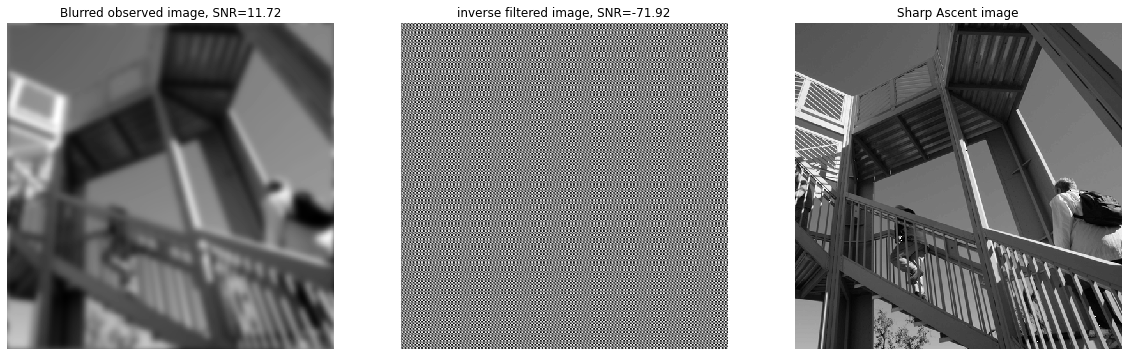

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].imshow(y_blur, interpolation="nearest", cmap="gray")
ax[0].axis("off")
ax[0].set_title("Blurred observed image, SNR={:.2f}".format(snr(x_sharp, y_blur)))
ax[1].imshow(y_inv, interpolation="nearest", cmap="gray")
ax[1].axis("off")
ax[1].set_title("inverse filtered image, SNR={:.2f}".format(snr(x_sharp, y_inv)))
ax[2].imshow(x_sharp, interpolation="nearest", cmap="gray")
ax[2].axis("off")
ax[2].set_title("Sharp Ascent image");

**Ouch!** The 'restored' image is in fact very bad and totally useless... **Why?**

Because the inverse filtering creates an explosion of the _numerical_ noise (numerical computations are never exact. 
There are some round-off errors that introduce a small amount of noise). Then if $Y(\nu)=  A(\nu) X(\nu)  + V_{num}(\nu)$, where $V_{num}(\nu)$ is the (Fourier Transform) numerical noise,  
$${\hat X}(\nu) = \frac{Y(\nu)}{ A(\nu)} = X_{sharp}(\nu) + \frac {V_{num}(\nu)} { A(\nu)},$$
where we may divide $V_{num}(\nu)$ by $0$, or near $0$ values. This creates the instability of the inversed filtered image, where pixel tends to plus or minus infinity (even if the numerical noise is very low).


## Deconvolution: Wiener smoothing (with regularization)

To avoid this explosion, we consider a simple regularization by assuming (not adding, just assuming) an **equivalent noise** in the deconvolution model. More precisely, we can assume for mathematical convenience that 
$$ \rho^{-1}(\nu) = \frac{\varepsilon}{|A(\nu)|^2} $$
where $\varepsilon>0$ is parameter that drives the power of the equivalent noise.

Thus the Wiener filter reads
$$G(\nu) = \frac{1}{A(\nu)} \frac{1}{1+\frac{\varepsilon}{|A(\nu)|^2} } =  \frac{A(\nu)^*}{ |A(\nu)|^2 + \varepsilon},$$
where the denominator is now always greater than $\varepsilon>0$ which prevents from filter instability when 
$\varepsilon$ is large enough.

We select now a value of the parameter $\varepsilon$  for the amount of _equivalent_ noise 

In [26]:
# small amount of equivalent noise
Epsilon = 1e-40

Perform the Wiener filtering for this equivalent noise model

In [27]:
xF_Wiener = yF * conj(aF) / (abs(aF) ** 2 + Epsilon)
x_Wiener = real(ifft2(xF_Wiener))

Display the image spectra

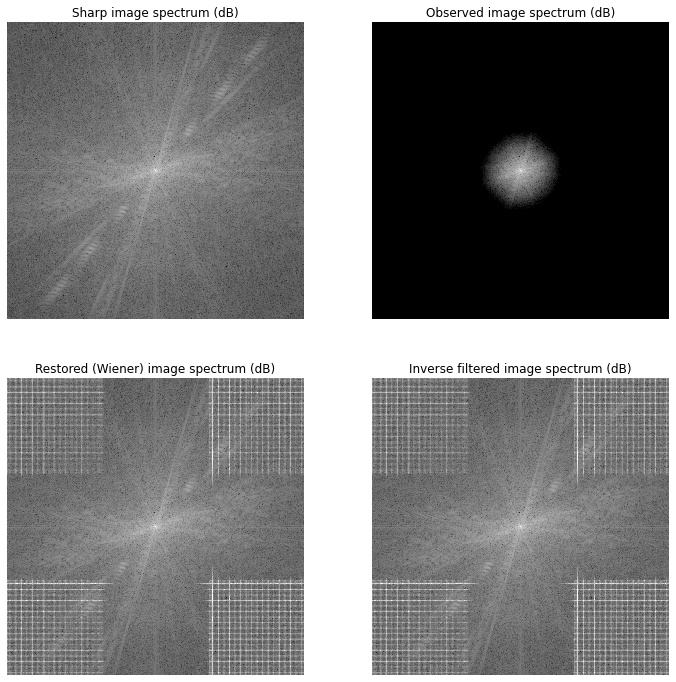

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
range_dB = 20 * log10(abs(fftshift(xF)))
vmin = range_dB.min()
vmax = range_dB.max()

ax[0, 0].imshow(
    20 * log10(abs(fftshift(xF))),
    vmin=vmin,
    vmax=vmax,
    interpolation="nearest",
    cmap="gray",
)
ax[0, 0].axis("off")
ax[0, 0].set_title("Sharp image spectrum (dB)")
ax[0, 1].imshow(
    20 * log10(abs(fftshift(yF))),
    vmin=vmin,
    vmax=vmax,
    interpolation="nearest",
    cmap="gray",
)
ax[0, 1].axis("off")
ax[0, 1].set_title("Observed image spectrum (dB)")
v = 20 * log10(abs(fftshift(xF)))
ax[1, 0].imshow(
    20 * log10(abs(fftshift(xF_Wiener))),
    vmin=vmin,
    vmax=vmax,
    interpolation="nearest",
    cmap="gray",
)
ax[1, 0].axis("off")
ax[1, 0].set_title("Restored (Wiener) image spectrum (dB)")
ax[1, 1].imshow(
    20 * log10(abs(fftshift(yF_inv))),
    vmin=vmin,
    vmax=vmax,
    interpolation="nearest",
    cmap="gray",
)
ax[1, 1].axis("off")
ax[1, 1].set_title("Inverse filtered image spectrum (dB)");

Display the restored images and SNRs

In [29]:
snr(x_sharp, x_Wiener)  # in dB

-30.76839032242979

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
ax[0, 0].imshow(y_blur, interpolation="nearest", cmap="gray")
ax[0, 0].axis("off")
ax[0, 0].set_title("Noisy observed image, SNR={:.2f}".format(snr(x_sharp, y_blur)))

ax[0, 1].imshow(x_sharp, interpolation="nearest", cmap="gray")
ax[0, 1].axis("off")
ax[0, 1].set_title("Sharp Ascent image")

ax[1, 0].imshow(y_inv, interpolation="nearest", cmap="gray")
ax[1, 0].axis("off")
ax[1, 0].set_title("Inverse filtered image, SNR={:.2f}".format(snr(x_sharp, y_inv)))


ax[1, 1].imshow(x_Wiener, interpolation="nearest", cmap="gray")
ax[1, 1].axis("off")
ax[1, 1].set_title("Wiener filtered image, SNR={:.2f}".format(snr(x_sharp, x_Wiener)));

## Compute and display the SNRs curve

Plot the SNR as a function of $\varepsilon$.
Note that it is better to use a log-scale for the dynamic of the $Epsilon$'s

In [31]:
epsilons = logspace(-35, 10, 100)  # log scale from 10^{-10} to 10^{-2}
snrs = ndarray(epsilons.shape)
biases = ndarray(epsilons.shape)
variances = ndarray(epsilons.shape)
mses = ndarray(epsilons.shape)
for i, l in enumerate(epsilons):
    tmp = real(ifft2(yF * aF / (abs(aF) ** 2 + l)))
    snrs[i] = snr(x_sharp, tmp)
    biases[i] = mean(x_sharp - tmp) ** 2  # squared bias
    variances[i] = var(x_sharp - tmp)
    mses[i] = mean((x_sharp - tmp) ** 2)  # squared bias + variance

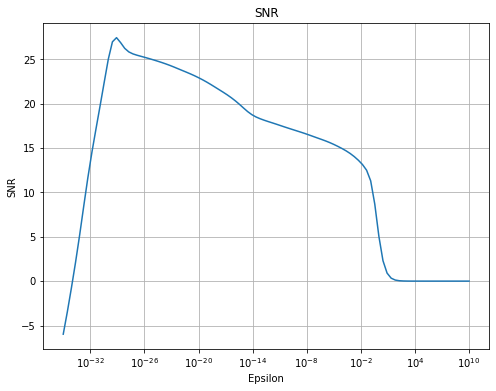

In [32]:
# Display
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.semilogx(epsilons, snrs)
ax.set_xlabel("Epsilon")
ax.set_ylabel("SNR")
ax.set_title("SNR")
ax.grid("On")

**Exercise:**
- Find the optimal solution here for $\varepsilon$
- Comment the shape of the SNR curves: what are the problems on each tail? In particular, what are the limiting solution when $\varepsilon$ tends to $0$ or $+\infty$?
- (Optional) Redo the same by adding some (say white Gaussian) noise on the observations `y_blur`, with a given variance $\sigma^2$ (say $\sigma=0.01$). Comment your results/findings
